In [136]:
# Causal Machine Learning for Treatment Effect Estimation

In [137]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans

from sklearn.preprocessing import Normalizer
import pickle

# get standard models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier

from sources.doubly_robust import doubly_robust
from sources.models.TARNet import TARnetICFR
from significance import *

import pickle
import torch
import torch.nn as nn
import torch.optim as optim

from auxiliary_propensity_on_outcomet0_without_print import data_processing, doubly_robust, visualise, visualise_ites, impute_missing_values_knn, run_model, undersample, full_contra_indications_tracker, value_based_contra_indications_tracker, period_decomposition,run_model_class
from icodes import encoding

# from datetime import timedelta
import warnings 
warnings.filterwarnings('ignore')

## 1. Introduction

The purpose of this notebook is to provide and end-to-end description of the treatment effect estimation process. This notebook consists of three parts:

1. **Data processing**: The first part is the data processing part. Here we basically prepare the data for the ML models.
2. **Causal ML Models**: The second part of the notebook consists of a series of causal ML learning models. In particular, we use the causal meta-learning framework. 
3. **Adadptive Model**: The third part of the notebook is also a machine learning model. However, contrary to the models before, this one was developed by the VU team and allows for more control over the estimation proces. 

Please find below an overview of the steps we will go through. Note that the boxes do not correspond one-to-one to sections in the notebook, but the general flow is the same. 

![alt text](images\ModellingOverview.jpg)

## 1.a. Preliminaries \& Design Choices

We first want to get some preliminaries out of the way. In particular, we would like to make some specific **design choices** explicit. Below, we can set the following parameters, thereby modifying specific choices:

- ``EXPOSURE_THRESHOLD``: The treatment is binary. However, how much treatment is provided can be changed with this variable. In essence, it determines the cut-off value. For instance, we can set it to 60 minutes in the case of physical therapy (in mins.). Then, patients with more then 60 minutes of PT will be assigned T=1, those below will be T=0.
- ``PERIOD_MIN``: Minimal time period between baseline measurement and followup measurement. N.B. If this is set too low, the effect may not yet register. Too high and the effect may have faded out. 
- ``PERIOD_MAX``: Maximal time period between baseline measurement and followup measurement. N.B. If this is set too low, effect may not yet register. Too high and the effect may have faded out.  
- ``REMOVE_MULTI_COL``: Whether or not to remove multicollinear columns. 
- ``CORRELATION_THRESHOLD``: Threshold for removing collinear columns. 
- ``UNDERSAMPLE``: Some models perform better when undersampling the minority class. For instance, if there are 1000 cases of patients with PT (T=0) and only 150 with PT (T=1), setting this to ``True`` ensures that 150 patients are sampled from PT (T=0), resulting in 300 observations in total.
- ``IMPUTE``: Whether or not to impute missing *covariate* values.
- ``PROPENSITY``: Whether or not to add a propensity score to the model.
- ``CLEAN_COMPARE``: By default (when this is set to ``False``), the data processing script assigns any observations below ``EXPOSURE_THRESHOLD`` to the control group and  any observation above ``EXPOSURE_THRESHOLD`` to treated. Setting this parameter to ``True`` creates a scenario where *only* observation that did not get any treatment are assigned to the control group. For instance, in the case of PT, we would have a control group of patients getting only 0 mins. of PT and a treated group of patients with, say, more than 60 mins. of PT.
- ``TREATMENT``: Name of the treatment variable.
- ``TARGET``: Name of the target variable.

In [138]:
# set seed
np.random.seed(42)

# set the exposure threshold for binary dichtomization. In the case of PT, 60 minutes of PT at least. 
EXPOSURE_THRESHOLD = 30 #30 # SET TO 30

# set the period between observations. We only consider the effects between 120 and 240 days after exposure. 
PERIOD_MIN = 90 # /MAYBE CHECK WITH 60? 160
PERIOD_MAX = 210 # CHECK WITH 120 DAYS 380

# if we want to move multicollinear columns, set to True
REMOVE_MULTI_COL = True

# set the threshold for multicollinearity drops 
CORRELATION_THRESHOLD = 0.6

# set to True if we want to undersample
UNDERSAMPLE = False #False #True

# set to True if we want to impute missing values
IMPUTE = True

PROPENSITY = True

# clean compare (to be used if only > threshold AND treatment = 0)
CLEAN_COMPARE = True

TREATMENT = 'in3eb' # (minutes or days of physical therapy)
OUTCOME = 'ij2b' 

Having set the desired parameters, we will now read in the data.

In [139]:
import pyreadstat
df = pd.read_csv("C:/Users/Paulina.Wisniewska/Desktop/df.csv",engine="python", encoding = 'cp1252')

# # read data
# df = pd.read_csv(file)
# print(f"Treatment before processing {len(df[df[TREATMENT]>EXPOSURE_THRESHOLD])}")

In [140]:
df = df.dropna(subset=['ij2b'])

In [141]:
to_discrete = lambda x: 1 if x >= 1 else 0
df['ij2b'] = df['ij2b'].apply(to_discrete)

In [142]:
df = df.dropna(subset=['ij2b'])

In [143]:
binary = lambda x: 1 if x >= EXPOSURE_THRESHOLD else 0

df['treatment'] = df[TREATMENT].apply(binary)  



## Create "Fake" Discrete Outcome to Represent Mortality or Hospitalization

In [144]:
# REMOVE THIS, JUST TO SHOW THAT THE CODE RUNS
df['hosp'] = np.random.choice([0,1], size = len(df))

In [145]:
df = df.dropna(subset=['ij2d'])
to_discrete = lambda x: 1 if x >= 1 else 0
df['ij2d'] = df['ij2d'].apply(to_discrete)

In [146]:
to_discrete = lambda x: 1 if x >= 1 else 0
df['ii1j'] = df['ii1j'].apply(to_discrete)

In [147]:
def recode(value):
    if value  == 0:
        return 0 
    elif 1<= value<=2 :
        return 1
    elif pd.isna(value):
        return np.nan
    else:
        return 2
    
df[['sDRS']] = df[['sDRS']].applymap(recode)


In [148]:
def recode(value):
    if value  == 0:
        return 0 
    elif 1<= value<=2 :
        return 1
    elif 3<= value<=4 :
        return 2
    elif pd.isna(value):
        return np.nan
    else:
        return 3
    
df[['sCPS']] = df[['sCPS']].applymap(recode)


In [149]:
def recode(value):
    if value  == 0 or value ==1:
        return 0 
    elif  value  == 2 or value ==3:
        return 1
#     elif 4<= value & value<=6 :
#         return 2
    elif pd.isna(value):
        return np.nan
    else:
        return 2
    
df[['sADLH']] = df[['sADLH']].applymap(recode)


In [150]:
# get number of classes
NUM_CLASSES = len(df[OUTCOME].dropna().unique())

In [151]:
df= df[df['sAGE_cat']>=60]

## Part 2. Data Processing

In this first part, we will carry out the data processsing. In particular, we would like to select the relevant covariates, make a pre-selection based on patient characteristics (e.g. whether or not contra-indications are present), select the relevant period of observation, impute missing *coviariate* values and, lastly, handle any multi-collinearity. 

Next, we define the lists of covariates, clinical indications and contra-indications

In [152]:
######################               PT            ################################

clinical_contra = ['ij6c','ij6a', 'ij6b' , 'ij2r'] 



# list relevant confounders
confounders = ['sADLH','sAGE_cat', 'ih1', 'ih3', 'il7',   'ii1e', 'ii1h', 'sCPS','ij2d',  'ij2c'] #  'sDRS ,'sADLH',

# x = ['ij2a','ij2b','ij2c','ij2d' ]
# conf

# ADD VALUE BASED CLINICAL INDICATIONS, E.G. {'sDRS' : [3,4]}

# list of other relevant variables
relevant_vars = ['A3', 'ID', TREATMENT, OUTCOME, 'iA2']

# print(len(contra_indications))



In [153]:
df = df.dropna(subset=['ij2c'])
to_discrete = lambda x: 1 if x >= 1 else 0
df['ij2c'] = df['ij2c'].apply(to_discrete)

In [154]:
df = df.dropna(subset=['ij2d'])
to_discrete = lambda x: 1 if x >= 1 else 0
df['ij2d'] = df['ij2d'].apply(to_discrete)

In [155]:
# df = df.dropna(subset=['sAGE_cat'])
to_discrete = lambda x: 1 if 60<=x <=79  else 2 if 80<=x <=89 else 3 if x>=90 else None
df['sAGE_cat'] = df['sAGE_cat'].apply(to_discrete)

Please note that you can get the meaning of the icodes by running the ``encoding``-function below. You only need to change the name of the ``code`` variable.

In [156]:
code = 'iA2'
print(encoding[(code).lower()])

Gender


### 2.a. Indications

### 2a. Contra-indications

Next, the first thing we want to do is to drop patients that have a contra-indication for the treatment in questions. In the code below, we specify the contra-indications. 

Finally, for some contra-indications we want to exclude based on particular values only. We can do this by running the script below. 

Having processed the contra-indications, we can now select the necessary columns in the data.

In [157]:
df = df[confounders+ clinical_contra+relevant_vars ]   #list(clinical_indications.keys())+
# print(f"Treatment after selecting covariates {len(df[df[TREATMENT]>=EXPOSURE_THRESHOLD])}")

In [158]:
# remove duplicated cols if necessary
df = df.loc[:,[True if i == False else False for i in df.T.index.duplicated(keep='first')]] 

### 2.b. Baseline-Followup Selection

Important to note here is that in this particular setup, our goal is to **estimate the outcome value at follow up from the covariates *and* outcome variable at baseline**. 

Below you find a schematic depiction of how we want to process the data. As you can see, there are two timelines:

1. **Timeline 1**: Naturally processes from baseline to follow up over time, without any intervention in the meantme.
2. **Timeline 2**: Same as before, but with the difference that not an intervention has take place at some point in time between baseline and follow up. 

![alt text](TimelineModels.jpg)

Our goal is therefore to, *for each observation*, take the values (**pre-treatment** covariates, outcome on baseline $y_{t}$) of baseline, and the  values at follow up (outcome on follow up $y_{t+1}$) and store it in a convenient manner. Important to note is that as patient may have *several* of these baseline-followup recors where sometimes an intervention may have occured and sometimes not. We decided to do this to, again, safe as much data as possible. 

Let us begin by first counting the number of assesments. We do this, because it is not possible to include patients without followup. 

In [159]:
# get number of assesments
counter = lambda x: len(df[df['ID']==x])

# count number of items
df['num_assesments1'] =df['ID'].apply(counter)

Let us select only observations with more than 2 assesments. 

In [160]:
# get number of assesments higher than 1
df = df[df['num_assesments1']>=2]


# print(f'{len(df)} observations remaining.')

In the code below, we want to process the data a bit further. First, we want to make sure that the date columns (``iA9``) is in the correct format. Then we want to order based on ID and date. Also, we want to drop missing dates (if there are any) and drop any duplicated observations. Lastly, we want to make sure that the outcome is in the right format (i.e. a ``float``).

In [161]:
# convert column to datetime 
df['A3'] = pd.to_datetime(df['A3']) 
# sort values by ID and date
df = df.sort_values(by = ['ID', 'A3'])
# drop nans on dates of assesment
df = df[df['A3'].isna()==False]
# drop duplicated values
df = df.drop_duplicates()
df[OUTCOME] = df[OUTCOME].astype(float)

### 2.c Drop Duplicated Values

Next, because there may be two assesments on the same date, we also want to drop those (regardless of the reason as inspecting that is beyond the scope of this project notebook). 

In [162]:
# Group by 'Clientid' and then apply the duplicate check on 'iA9' within each group
duplicated_indices = df.groupby('ID').apply(
    lambda x: x[x['A3'].duplicated()].index).explode()

# Drop NaN values from the index list if they exist
duplicated_indices = duplicated_indices.dropna()

# Convert the result into a list if it's not empty
if not duplicated_indices.empty:
    duplicated_indices = duplicated_indices.tolist()

    # Drop the duplicates using the list of indices
    df = df.drop(index=duplicated_indices)

### 2.d. Clean Compare
If we want to only compare between those patients that receive either 0 treatment or a treatment above the threshold value, we run this code.

In [163]:
if CLEAN_COMPARE:
    df = df[(df[TREATMENT] <= 0) | (df[TREATMENT] >= EXPOSURE_THRESHOLD)]

### 2.e Period Decomposition

The piece of code (i.e. the function ``period_decomposition``) below is a loop that basically does the following:

1. Create a temporary dataframe ``temp_df``. We do this to make sure that there is an empty entity (i.e. data storage) to which we can append new, cleaned and processed observations.
2. Then, for each patient we do the following:
3. Look at all the observation dates.
4. Select the target outcome at follow up and at baseline.
5. Append each period to the ``temp_df`` *until running out of dates*. 
6. Move to the next patient. 

In [164]:
def period_decomposition(df, target):
    # List to store the rows of the new DataFrame
    rows = []

    # Unique client IDs
    client_ids = df['ID'].unique()
    total = len(client_ids)

    for count, client_id in enumerate(client_ids, start=1):
        # Inform the user about the progress
        if count % 1000 == 0 or count == total:
            print(f'{count} of {total} items completed...')

        # Extract rows for the current client
        client_rows = df[df['ID'] == client_id].sort_values('A3')
        client_dates = client_rows['A3'].tolist()

        for i in range(len(client_dates) - 1):
            baseline_date = client_dates[i]
            followup_date = client_dates[i + 1]

            # Extract the rows for baseline and follow-up
            baseline_row = client_rows[client_rows['A3'] == baseline_date]
            followup_row = client_rows[client_rows['A3'] == followup_date]

            # Calculate the outcomes
            outcome_t0 = float(baseline_row[target])
            outcome_t1 = float(followup_row[target])

            # Prepare a new row with all necessary information
            new_row = baseline_row.iloc[0].to_dict()
            new_row['OutcomeT0'] = outcome_t0
            new_row['OutcomeT1'] = outcome_t1
            new_row['OutcomeT0Date'] = baseline_date
            new_row['OutcomeT1Date'] = followup_date
            rows.append(new_row)

    # Create a new DataFrame from the list of new rows
    temp_df = pd.DataFrame(rows)
    print("Completed.")
    return temp_df


In [165]:
df = period_decomposition(df, target = OUTCOME)
print(f"Treatment after processing {len(df[df[TREATMENT]>EXPOSURE_THRESHOLD])}")

1000 of 3231 items completed...
2000 of 3231 items completed...
3000 of 3231 items completed...
3231 of 3231 items completed...
Completed.
Treatment after processing 611


In [166]:
contra_indications = {  'ij6c': [1,2,3,4,5,6,7,8],   #ij6a
                      'ij6b':[1,2,3,4,5,6,7,8],   'ij6a': [1,2,3,4,5,6,7,8] ,'ij2r':[1,2,3,4,5,6,7,8]      }    #

In [167]:
for column, bad_values in contra_indications.items():
    df = df[~df[column].isin(bad_values)]

### 2.f Dichotomize Treatment Variable

Because our model can only deal with binary treatments, we need to convert the continuous treatments into binary ones. We will do that using a simple fuctions. Recall that the threshold has been set using the ``EXPOSURE_THRESHOLD`` variable above.

In [168]:
binary = lambda x: 1 if x >= EXPOSURE_THRESHOLD else 0
# convert treatment to binary
df['treatment'] = df[TREATMENT].apply(binary)  
df = df.drop(columns = [TREATMENT])

In [169]:
# drop rows with missing outcome or treatment 
df = df.dropna(subset = ['OutcomeT0', 'OutcomeT1', 'treatment'])


### 2.g Select Relevant Period

Because the base data is too crude (the time periods between follow-up and baseline may be too far apart), we want to select a suitable period between observations. In essence, we aim to select a time window which is, on the one hand, determined by the minimum time (``PERIOD_MIN``) between baseline measurement and follow-up measurement and the maximum of that time window (``PERIOD_MAX``).

In [170]:
# get difference between dates
df['date_diff'] = df['OutcomeT1Date'] - df['OutcomeT0Date'] 
df['date_diff'] = df['date_diff'].dt.days 

# select relevant period
df = df[df['date_diff'] <= PERIOD_MAX]
df = df[df['date_diff'] >= PERIOD_MIN]

# df = df.drop_duplicates(subset='Clientid')


df = df.drop(columns = ['OutcomeT1Date', 'OutcomeT0Date', 'date_diff', 'A3', OUTCOME, 'ID'])
# examine how many treatment observations are left
len(df[df['treatment']==1])

541

### 2.h Impute Missing Values

In this part, we impute missing values. We use a standard KNN-imputer. If desired, it is possible to change the number of neighbours. Keep in mind that we can set this to ``False`` if we do not want to run it,

In [171]:
#imputing = IMPUTE
if IMPUTE:
    df = impute_missing_values_knn(df, n_neighbors=5)
else:
    df = df.dropna()
    print(len(df[df['treatment']==1]))

In [172]:
def recode(value):
    if value <= 0.5:
        return 0 
    elif 0.5<= value<=1.5 :
        return 1
    elif 1.5<= value<=2.5 :
        return 2
    elif 2.5<= value<=3.5 :
        return 3
    elif pd.isna(value):
        return np.nan

    
df[['sCPS']] = df[['sCPS']].applymap(recode)


### 2.i Handle Multicollinearity

Here we will handle multi-collinear columns. Keep in mind that we can set this to ``False`` if we do not want to run it,

### 2.j Handle Empty Columns

In the process, it may be that we end up with columns that contain only $0$ values. We want to drop these columns, as they are not informative.

In [173]:
# drop num_assesment column, not relevant anymore
df = df.drop(columns = ['num_assesments1'])
# get a list of coviariate columns
X = df.drop(columns = ['OutcomeT1', 'OutcomeT0', 'treatment']).columns

# drop columns that only have 0 values
for col in X:
    if len(df[df[col]==0]) == len(df):
        print(f"{col} - {encoding[col.lower()]} dropped." )
        df = df.drop(columns = [col])

ij6c - End-stage disease, 6 or fewer months to live dropped.
ij6a - Conditions diseases make cognitive, ADL, mood, or behavior patterns unstable dropped.
ij6b - Experiencing an acute episode, or a flare-up of a recurrent or chronic problem dropped.
ij2r - GI or GU bleeding dropped.


### 2.k Store CSV

In the last part of this notebook, we will store that data.

In [174]:
# ADD SKIP FOR TREATMENT AND OUTCOME T1
covars = [str(i) for i in df.columns]
covar_names = []

#print(encoding[(code).lower()])

for covar in covars:
    if (covar != 'treatment') and (covar != 'OutcomeT1'):

        try:
            covar_names.append(encoding[(covar).lower()])
        except:
            covar_names.append(covar)

        

In [175]:
covar_names

['sADLH ADL hierarchy scale (0-6)',
 'sAGE_cat',
 'Bladder continence',
 'Bowel continence',
 'Foot problems, eg bunions, hammertoes, overlapping toes, structural problems, infections, ulcers',
 'Hemiplegia',
 'Parkinsons disease',
 'sCPS Cognitive Performance Scale 0-6 range-Morris 1991',
 'Unsteady gait',
 'Dizziness',
 'Gender',
 'OutcomeT0']

In [176]:
covars

['sADLH',
 'sAGE_cat',
 'ih1',
 'ih3',
 'il7',
 'ii1e',
 'ii1h',
 'sCPS',
 'ij2d',
 'ij2c',
 'iA2',
 'OutcomeT0',
 'OutcomeT1',
 'treatment']

In [177]:

def recode(value):
    if 0<=value  <= 0.5:
        return 0 
    elif value >0.5:
        return 1
    else:
        return value
    
df[[ 'ii1h','ii1e']]=df[[ 'ii1h','ii1e']].applymap(recode)     #  ', 


In [178]:
# 'ii1k', 'ii1l'
def recode(value):
    if value == 0:
        return 0 
    elif value ==8:
        return 8
    elif value >0:
        return 1
    else:
        return value
    
df[['ih1', 'ih3']] = df[['ih1', 'ih3']].applymap(recode)


In [179]:
def recode(value):
    if value <= 0.5:
        return 0 
    elif 0.5< value:
        return 1
    else:
        return value
    
df[['il7']] = df[['il7']].applymap(recode)


In [180]:
# df['ih3'].value_counts()

In [181]:
df= df[(df['ih1'] != 8) & (df['ih3'] != 8)]


In [182]:
df = pd.get_dummies(df , columns = [ 'sAGE_cat','sADLH','sCPS'], dtype =int, drop_first =True)   # 

In [183]:
df.to_csv(f"Z:/Paulina Wiśniewska/03-10-2023-Dutch_LTCF_cleaned_data_with_selected_covar_{TREATMENT}-{OUTCOME}.csv", index = False)

In [184]:
# quick model
clf = RandomForestClassifier()

# get data
X = df.drop(columns = ['OutcomeT1'])
y = df['OutcomeT1']

# train model
clf.fit(X, y)
importances = clf.feature_importances_
feature_names = [] #X.columns

# get col names
for col in X.columns:
    try:
        feature_names.append(encoding[(col).lower()])
    except:
        feature_names.append(col)

# get feature importance
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by = 'importance', ascending = False)

feature_importances

,feature,importance
8,OutcomeT0,0.602048
5,Unsteady gait,0.062013
13,sADLH_2.0,0.048646
1,Bowel continence,0.036391
9,treatment,0.027751
0,Bladder continence,0.026697
7,Gender,0.025640
12,sADLH_1.0,0.024433
2,"Foot problems, eg bunions, hammertoes, overlap...",0.022563
6,Dizziness,0.021501


In [185]:
zmienne = ['OutcomeT0']

### Note to Teams: Please Start Here

**MAKE SURE THAT THE DATA IS IN THE EXACT FORMAT AS BELOW.**

Checklist:

1. The covariates must come first.
2. Then, there must be the outcome at baseline called ``OutcomeT0``.
3. There must be an outcome at followup called ``OutcomeT1``.
4. You may have a propensity score columns (``ps``), but this is not required. Same for clusters.
5. There must be a treatment column *at the end* called ``treatment``. 

Good luck!

## Part 3. Machine Learning

Having processed the data, we can now move on the the machine learning (ML) part. Recall that we model using the meta-learning paradigm. Below is a schematic depiction of the process.

![alt text](images\ModelGoal.jpg)

As can be seen, for a given patient, we can - *after training* - provide the details of that patient. These details are the outcome at baseline (``OutcomeT0``), the covariates and whether or not we include treatment. This allows us to compute the **individual treatment effect** (ITE), the predicted effect unter treatment minus the predicted effect under control.

However, before we are able to estimate the ITE for a patient, we need to train the model. In meta-learning we always train two models. The first model is trained on the control group and the second model is trained on the treated group. Let us now first state what the ``outcome`` and ``intervention`` variables are.  

![alt text](images\GeneralPlotTrajectoryInterpretation.jpg)

Next, we want to select the models. Here we will use ``RandomForestClassifier()``.

In [186]:
model0 = RandomForestClassifier()
model1 = RandomForestClassifier()

In [187]:
model = model0

In [188]:
# File path for the Excel file
excel_file = f'C:/Users/Paulina.Wisniewska/Desktop/Do_wyslania/hyperparameters/model_hyperparameters_RandomForest.xlsx'

# Create a Pandas Excel writer using XlsxWriter as the engine
with pd.ExcelWriter(excel_file, engine='xlsxwriter') as writer:
    # Get hyperparameters
    hyperparameters = model.get_params()

    # Convert to DataFrame
    df = pd.DataFrame([hyperparameters])

    # Write each model's hyperparameters to a different sheet
    df.to_excel(writer, sheet_name="RandomForest")

print("Hyperparameters of models have been saved to 'model_hyperparameters.xlsx'.")

Hyperparameters of models have been saved to 'model_hyperparameters.xlsx'.


Then, we want to retrieve the data. We can use the data from above, but here we will read the file. 

In [189]:
# call your data file here
FILE = f"Z:/Paulina Wiśniewska/03-10-2023-Dutch_LTCF_cleaned_data_with_selected_covar_{TREATMENT}-{OUTCOME}.csv"

In [190]:
from sklearn.impute import KNNImputer
import numpy as np
import pandas as pd
import pickle

# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample


#from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, roc_auc_score,classification_report,confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV

# get standard models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor

from sklearn.cluster import KMeans
import numpy as np


from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import os
import pickle

In [191]:

def data_processing1(file, undersampled, include_propensity, machine, intervention, outcome, target='OutcomeT1', treatment='treatment', caliper=0.2, zmienne=None):
    """
    Przetwarza dane, przeprowadza undersampling, oblicza propensity score dla contraindications,
    ale bez dzielenia na train/test w przypadku clinicalindications.
    """
    # Wczytanie danych
    
    data = pd.read_csv(file)
#     print(data.dtype)
    
    
    
#     data = pd.get_dummies(data =, columns = ['ih1', 'ih3', 'il7', 'ij2d', 'ij2c', 'ij2b','iA2'], drop_first=True , dtype =int)
#     print(data.dtypes)
    
    
    # Przeprowadzenie undersamplingu
    if undersampled:
        freq_treated = len(data[data[treatment] == 1])
        control = data[data[treatment] == 0].sample(freq_treated)
        treated = data[data[treatment] == 1]
        data = pd.concat([control, treated])

#     print(f'DF length : {len(data)}')
#     print(f"Control class: {data[data[treatment] == 0].shape[0]}")
#     print(f"Treated class: {len(data[data[treatment] == 1])}")

    # Usuwanie braków danych
    data = data.dropna(axis=1)
    # Izolacja zmiennych
    X = data.drop(columns=[target, 'treatment']).columns
    outcomes = target
    # Obliczanie propensity score tylko dla contraindications, jeśli podano
    if zmienne is not None:
        # Wybieramy tylko kolumny związane z contraindications
        # The change is here: using double square brackets to create a DataFrame
        X_treated = data.query(f'{treatment} == 1')[zmienne]
        X_control = data.query(f'{treatment} == 0')[zmienne]

        # Dopasowanie modelu regresji logistycznej dla propensity score
        ps_model = LogisticRegression(C=1e2, max_iter=10000).fit(
            pd.concat([X_control, X_treated]),  # X_combined = X_control + X_treated
            pd.concat([data.query(f'{treatment} == 0')[treatment], data.query(f'{treatment} == 1')[treatment]])  # y_combined = control + treated
        )
#         print(f"Intercept (β0): {ps_model.intercept_[0]}")
#         print(f"Coefficient for  (β1): {ps_model.coef_[0][0]}")
#         print(ps_model.coef_)
        
        
        
        # example, replace if you have more variables
        # Dodanie propensity score do grupy treated i control
        data.loc[data[treatment] == 1, 'ps'] = ps_model.predict_proba(X_treated)[:, 1]
        data.loc[data[treatment] == 0, 'ps'] = ps_model.predict_proba(X_control)[:, 1]
#         print(f"Data after adding propensity scores:")
#         print(data[['ps']].head())
        
     
#         display(data.head(30))
    else:
        ps_model = None# Jeżeli nie podano clinicalindications, nie obliczamy propensity score

    # Jeśli include_propensity == False, usuwamy kolumnę 'ps' z całego zbioru danych
    if not include_propensity:
        data.drop(columns=['ps'], inplace=True, errors='ignore')
    # Zapisywanie modelu propensity score, jeśli został obliczony
    if ps_model:
        os.makedirs('storage', exist_ok=True)
        filename_prob_score_model = f"storage/propensity_score_model_{intervention}-{outcome}.sav"
        pickle.dump(ps_model, open(filename_prob_score_model, 'wb'))

    treated_data = data[data[treatment] == 1]
    control_data = data[data[treatment] == 0]

    #Sortowanie po propensity score
    treated_data_sorted = treated_data.sort_values(by='ps')
    control_data_sorted = control_data.sort_values(by='ps')
#     print(treated_data_sorted)
#     print(control_data_sorted)

#     import matplotlib.pyplot as plt

# # Wykres rozkładu `ps` dla grupy leczonej i kontrolnej
    plt.hist(treated_data_sorted['ps'], bins=20, alpha=0.5, label='Treated')
    plt.hist(control_data_sorted['ps'], bins=20, alpha=0.5, label='Control')
    plt.legend()
    plt.show()
# #     #Lista dopasowanych par

    display(treated_data_sorted['ps'].value_counts())
    display(control_data_sorted['ps'].value_counts())

    matched_pairs = []
    matched_controls = set()  # Zbiór, aby uniknąć duplikatów

#     display(treated_data_sorted)
# Dopasowanie na podstawie najbliższej wartości propensity score z uwzględnieniem caliper
    for idx_treated, row_treated in treated_data_sorted.iterrows():
    # Szukamy wszystkich możliwych dopasowań w granicach caliper

        possible_matches = control_data_sorted[(control_data_sorted['ps'] - row_treated['ps']).abs() <= caliper]


        if not possible_matches.empty:
        # Szukamy wszystkich możliwych dopasowań i bierzemy tylko te, które jeszcze nie zostały dopasowane
            possible_matches = possible_matches[~possible_matches.index.isin(matched_controls)]


            if not possible_matches.empty:
            # Dopasuj wszystkich kontrolnych pacjentów, którzy spełniają warunek caliper
                closest_match = possible_matches.iloc[(possible_matches['ps'] - row_treated['ps']).abs().argmin()]
                matched_controls.add(closest_match.name)
                matched_pairs.append((idx_treated, closest_match.name))

# Liczymy liczbę dopasowanych przypadków
    matched_treated_count = len(matched_pairs)
    unmatched_treated_count = len(treated_data_sorted) - matched_treated_count
    unmatched_control_count = len(control_data_sorted) - matched_treated_count

#     print("\n--- Summary of Propensity Score Matching ---")
#     print(f"Total treated (leczonych): {len(treated_data_sorted)}")
#     print(f"Total control (kontrolnych): {len(control_data_sorted)}")
#     print(f"Matched treated: {matched_treated_count}")
#     print(f"Unmatched treated: {unmatched_treated_count}")
#     print(f"Matched control: {matched_treated_count}")
#     print(f"Unmatched control: {unmatched_control_count}")

# Wypisujemy dopasowane pary
#     print("\n--- Matched Pairs ---")
#     for treated_index, control_index in matched_pairs:
#         print(f"Treated patient (index: {treated_index}) matched with Control patient (index: {control_index})")



# Zbieramy dopasowane dane
    treated_matched_data = [treated_data_sorted.loc[matched_pairs[i][0]] for i in range(matched_treated_count)]
    control_matched_data = [control_data_sorted.loc[matched_pairs[i][1]] for i in range(matched_treated_count)]

# Łączymy obie listy danych w jeden DataFrame
    matched_data = pd.DataFrame(treated_matched_data + control_matched_data)
    treated_matched_data =pd.DataFrame(treated_matched_data)
    control_matched_data =pd.DataFrame(control_matched_data)

# Zapisujemy dane do pliku CSV
    matched_data.to_csv(f"matched_data_{intervention}_{outcome}.csv", index=False)

# Wyświetlamy dane
#     print(matched_data)
    matched_data1 = matched_data.drop('ps', axis=1)
#     for x in zmienne:
#         print(f"OUTCOMET0 for treatment:")
#         print(treated_matched_data[x].value_counts())
#         print("")
#         print(f"OUTCOMET0 for control:")
#         print(control_matched_data[x].value_counts())

    matched_data1 = matched_data1.drop(zmienne, axis=1)
#     print(matched_data1.columns.to_list())
#     print(matched_data1)

    OutcomeT1 ='OutcomeT1'
    print("")
    print("")
    print("")
    y_control =matched_data1.query('treatment==0')['OutcomeT1']
    X_control =matched_data1.drop(columns=OutcomeT1).query('treatment==0')
    #print(f"Mean_control_outcomeT0: {X_control['OutcomeT0'].mean()}")
#     display(f"y_control: {len(y_control)}")
#     display(f"X_control: {len(X_control)}")
    print("")
    print("")
    print("")
    y_treated =matched_data1.query('treatment==1')['OutcomeT1']
    X_treated =matched_data1.drop(columns=OutcomeT1).query('treatment==1')
   # print(f"Mean_treatment_outcomeT0: {X_treated['OutcomeT0'].mean()}")
#     display(f"y_treated: {len(y_treated)}")
#     display(f"X_treated: {len(X_treated)}")
#     print("")
#     print("")
#     print("")
    
#     print("Statystyki opisowe dla zmiennych, ktore zostaly:")
#     print("")
#     print("Grupa treatment")
#     for x in X_treated:
#         print(f"{x}:")
#         display(X_treated[x].value_counts().sort_index())
#         print("")
#     print("")
#     print("")
#     print("Grupa control")
#     print("")
#     for x in X_control:
#         print(f"{x}:")
#         display(X_control[x].value_counts().sort_index())
#         print("")
    
    
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_control, y_control, test_size = 0.3)
    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_treated, y_treated, test_size = 0.3)
    
    
    X_train_c = X_train_c.drop(columns =['treatment'])
    
#     print("Control")

#     for col in X_train_c.columns:
#         print(col)
#         print(X_train_c[col].value_counts())
#         print('')
#     print("")
#     print("")
    
    
#     print("Treatment")
#     for col in X_train_t.columns:
#         print(col)
#         print(X_train_t[col].value_counts())
#         print('')
    X_train_t = X_train_t.drop(columns =['treatment'])
    X_test_c  = X_test_c.drop(columns =['treatment'])
    X_test_t  = X_test_t.drop(columns =['treatment'])
    
    X_combined_c = pd.concat([X_train_c, X_test_c], axis =0).reset_index(drop=True)
    X_combined_t = pd.concat([X_train_t, X_test_t], axis =0).reset_index(drop=True)



    return X_train_c, X_test_c, y_train_c, y_test_c, X_train_t, X_test_t, y_train_t, y_test_t,X_combined_c,X_combined_t

In [192]:
import statsmodels.api as sm

In [193]:
def run_model_class1(n_bootstraps, file, model1, model2, machine, intervention, outcome, include_propensity, undersampled = False, num_iter = 1, zmienne =None):
    
    acc_c, acc_t, f1_c, f1_t = [], [], [], []
    train_acc_c, train_acc_t = [], []
    
    X_train_c, X_test_c, y_train_c, y_test_c, X_train_t, X_test_t, y_train_t, y_test_t,X_combined_c,X_combined_t= data_processing1(file, undersampled,
                                                                                                         include_propensity, machine,
                                                                                                         intervention, outcome,
                                                                                                         target='OutcomeT1',
                                                                                                         treatment='treatment', caliper=0.2,
                                                                                                       zmienne =zmienne )
   
    print("")

   
   
    f_c = model1
    f_c.fit(X_train_c, y_train_c)
    predictions_c = f_c.predict(X_test_c)
    predictions_c_proba = f_c.predict_proba(X_test_c)[:,1]
#     print(predictions_c_proba)
    print("CONTROL:")
    coefficients_c =model1.coef_[0]
#     print("WSPOLCZYNNIKI:", coefficients_c)
    odds_ratios_c =np.exp(coefficients_c)
#     print("OR", odds_ratios_c)
    df_CONTROL = pd.DataFrame({
        'Cecha': X_train_c.columns, 
        'WSPOLCZYNNIKI': coefficients_c,
        'OR' :odds_ratios_c
    })
#     print(df_CONTROL)
    
    np.random.seed(42)

    # treated
    f_t = model2
    f_t.fit(X_train_t, y_train_t)
    predictions_t = f_t.predict(X_test_t)
    predictions_t_proba = f_t.predict_proba(X_test_t)[:,1]
    np.random.seed(42)

    print("TREATMENT:")
    coefficients_t =model2.coef_[0]
#     print("WSPOLCZYNNIKI:", coefficients_t)
    odds_ratios_t =np.exp(coefficients_t)
#     print("OR", odds_ratios_t)
    df_TREATMENT = pd.DataFrame({
        'Cecha': X_train_t.columns, 
        'WSPOLCZYNNIKI': coefficients_t,
        'OR' :odds_ratios_t
        
        
    })
#     print(df_TREATMENT)
    
    
    
#     np.random.seed(42)
#     X_c = sm.add_constant(X_train_c)   
#     X_t = sm.add_constant(X_train_t)
#     model0 =sm.Logit(y_train_c, X_c)
#     model1 =sm.Logit(y_train_t, X_t)
# #     model0 =sm.OLS(y_train_c, X_train_c)
# #     model1 =sm.OLS(y_train_t, X_train_t)
#     result0 =model0.fit()
#     result1 = model1.fit()  
# #     y_pred_c =result0.predict( sm.add_constant(X_train_c))
# #     print(y_pred_c)
    
# #     y_pred_t =result1.predict(sm.add_constant(X_train_t))
# #     print(y_pred_t)
#     print(result0.summary())
#     print(result1.summary())
    
    
    
    

    acc_c.append(accuracy_score(predictions_c, y_test_c))
    acc_t.append(accuracy_score(predictions_t, y_test_t))
    
    roc_auc_c = roc_auc_score(y_test_c, predictions_c_proba)
    roc_auc_t = roc_auc_score(y_test_t, predictions_t_proba)
#######################     ROC     AUC    ###############################################################
    print("CONTROL")

#     fpr_c, tpr_c, thresholds_c = roc_curve(y_test_c,predictions_c_proba)
#     roc_auc_c = auc(fpr_c, tpr_c)
#     plt.figure()
#     plt.plot(fpr_c, tpr_c, color ='gray', lw=2, label = f'ROC curve CONTROL (AUC = {roc_auc_c: .2f})')
#     plt.plot([0,1], [0,1], color ='black', lw=2, linestyle ='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Difficulty turning around, 30 minutes physical therapy per week')
#     plt.legend(loc = 'lower right')
#     plt.show()
    
    
    
#     print("confusion_matrix CONTROL")
#     display(confusion_matrix(y_test_c,predictions_c))
#     print("")
#     print(classification_report(y_test_c,predictions_c))
    
    
#     print("TREATMENT")
    
    
#     fpr_t, tpr_t, thresholds_t = roc_curve(y_test_t,predictions_t_proba)
#     roc_auc_t = auc(fpr_t, tpr_t)
#     plt.figure()
#     plt.plot(fpr_c, tpr_c, color ='black', lw=2, label = f'ROC curve TREATMENT (AUC ={roc_auc_t: .2f})')
#     plt.plot([0,1], [0,1], color ='black', lw=2, linestyle ='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Difficulty turning around, 30 minutes physical therapy per week')
#     plt.legend(loc = 'lower right')
#     plt.show()
    
#     print("confusion_matrix TREATMENT")
#     display(confusion_matrix(y_test_t,predictions_t))
#     print("")
#     print(classification_report(y_test_t,predictions_t))
    
    
    
    
    
###########################################################################################################

    
    
#     f1_c.append(f1_score(predictions_c, y_test_c))
#     f1_t.append(f1_score(predictions_t, y_test_t))

    predictions_c_train = f_c.predict(X_train_c)
    predictions_t_train = f_t.predict(X_train_t)
    
    train_acc_c.append(accuracy_score(predictions_c_train, y_train_c))
    train_acc_t.append(accuracy_score(predictions_t_train, y_train_t))

    # compute ITEs for test
    ites_t_test = f_t.predict(X_test_t) - f_c.predict(X_test_t)
    ites_c_test = f_t.predict(X_test_c) - f_c.predict(X_test_c)
    # compute Individual treatment effects
    ites_test = np.append(ites_t_test, ites_c_test)
    
    
    
    
    
    outcome_under_treatment = np.concatenate([f_t.predict(X_test_t), f_t.predict(X_test_c)])
    outcome_under_treatment = np.mean(outcome_under_treatment)
#     print(f"Test outcome under treatment {outcome_under_treatment}.")
    
    outcome_under_control = np.concatenate([f_c.predict(X_test_t), f_c.predict(X_test_c)])
    outcome_under_control = np.mean(outcome_under_control)
    print(f"Test outcome under treatment {outcome_under_control}.")
    
    print(f"(Test) ATE {outcome_under_treatment - outcome_under_control}.")
    
    
    
    

    # compute ITEs for train
    ites_t_train = f_t.predict(X_train_t) - f_c.predict(X_train_t)
    ites_c_train = f_t.predict(X_train_c) - f_c.predict(X_train_c)
    # compute Individual treatment effects
    ites_train = np.append(ites_t_train, ites_c_train)
    itest_treatment = np.append(ites_t_train,ites_t_test)

    # compute relevant errors and record 
    results = {'ACC_C (Test)': np.mean(acc_c),
               'ACC_T (Test)': np.mean(acc_t),
              'ACC_C (Train)': np.mean(train_acc_c),
              'ACC_T (Train)': np.mean(train_acc_t),
              'ROC_AUC_C': roc_auc_c,
              'ROC_AUC_T': roc_auc_t,
              }

    hyperparameters = f_t.get_params()
    print(hyperparameters)

    # Convert to DataFrame
    df = pd.DataFrame([hyperparameters])
    df.to_csv(f'hyperparameters/model_hyperparameters_{machine}.csv')

    metrics = pd.DataFrame.from_dict(results, orient = 'index', columns = [machine])
    metrics.to_csv(f"results/model_results_{machine}_{intervention}-{outcome}.csv")
    
    filename_t = f"storage/model_t_{machine}_{intervention}-{outcome}.sav"
    filename_c = f"storage/model_c_{machine}_{intervention}-{outcome}.sav"

    # save models
    pickle.dump(f_t, open(filename_t, 'wb'))
    pickle.dump(f_c, open(filename_c, 'wb')) 
    
    
#     # Calculate confidence intervals for predictions
#     lower_c, upper_c = bootstrap_confidence_intervals(f_c, X_test_c, y_test_c)
#     lower_t, upper_t = bootstrap_confidence_intervals(f_t, X_test_t, y_test_t)

#     # Print prediction intervals
#     print("Control group prediction intervals:")
#     print("Lower:", lower_c)
#     print("Upper:", upper_c)

#     print("\nTreatment group prediction intervals:")
#     print("Lower:", lower_t)
#     print("Upper:", upper_t)


    # Compute ITEs for test
    ites_t = f_t.predict(X_test_t) - f_c.predict(X_test_t)
    ites_c = f_t.predict(X_test_c) - f_c.predict(X_test_c)

    # Compute individual treatment effects
    ites_test = np.concatenate([ites_t, ites_c])
    
    # Compute ITEs for test
    ites_t_proba = f_t.predict_proba(X_test_t)[:,1] - f_c.predict_proba(X_test_t)[:,1]
    ites_c_proba = f_t.predict_proba(X_test_c)[:,1] - f_c.predict_proba(X_test_c)[:,1]

    # Compute individual treatment effects
    ites_test_proba = np.concatenate([ites_t_proba, ites_c_proba])
    
#     ate_confidence(model0, model1, machine, X_train_c, X_test_c, y_train_c, y_test_c, X_train_t, X_test_t, y_train_t, y_test_t, n_bootstraps = n_bootstraps, )
    

    return metrics, predictions_t, predictions_c, y_test_t, y_test_c, ites_test,itest_treatment, ites_train, X_test_t, X_test_c, X_train_c, X_train_t, ites_test_proba,X_combined_c,X_combined_t



In [194]:
def visualise_ites1(ites, machine, target, intervention, split="test"): 
    ites = [i[0] for i in ites.reshape(-1,1)]
    ites = sorted(list(ites))

    x_values = range(1, len(ites) + 1)
    stdev = np.std(ites)
    upper_bound = [val + stdev for val in ites]
    lower_bound = [val - stdev for val in ites]

    sns.set(style="whitegrid")

    #plt.figure(figsize=(8,4))
    plt.figure(figsize=(12,6))

    plt.fill_between(x_values, lower_bound, upper_bound, color='gray', alpha=0.2, label="standard deviation")
    plt.axhline(y=np.mean(ites), color='darkred', linestyle='--', label='ATE estimate')
    plt.xlabel("Ordered Patient Indices")
    plt.ylabel(f"Individual Treatment Effect")
    plt.title(f"Difficulty turning around, 30 minutes physical therapy per week")
    
    print(f"ATE {np.mean(ites)}")

    sns.lineplot(x=x_values, y=ites, marker='o', color='black', label='predicted ITE values', ci=stdev)
    plt.savefig(f"plots/{machine}-{intervention}-{target}.png", dpi=300)

    plt.show()
    

LogisticRegression(penalty='none')


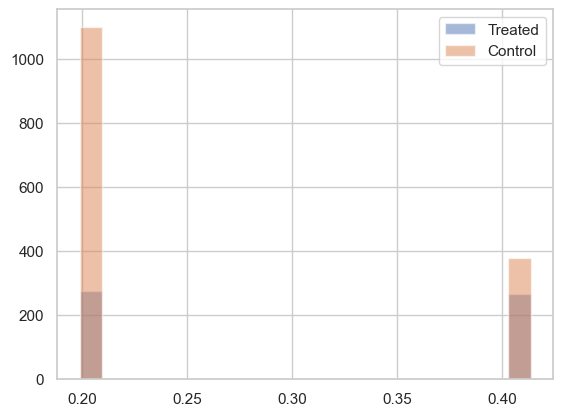

0.198842    273
0.413669    266
Name: ps, dtype: int64

0.198842    1100
0.413669     377
Name: ps, dtype: int64








CONTROL:
TREATMENT:
CONTROL
Test outcome under treatment 0.6296296296296297.
(Test) ATE -0.12345679012345678.
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'none', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
ATE -0.12345679012345678


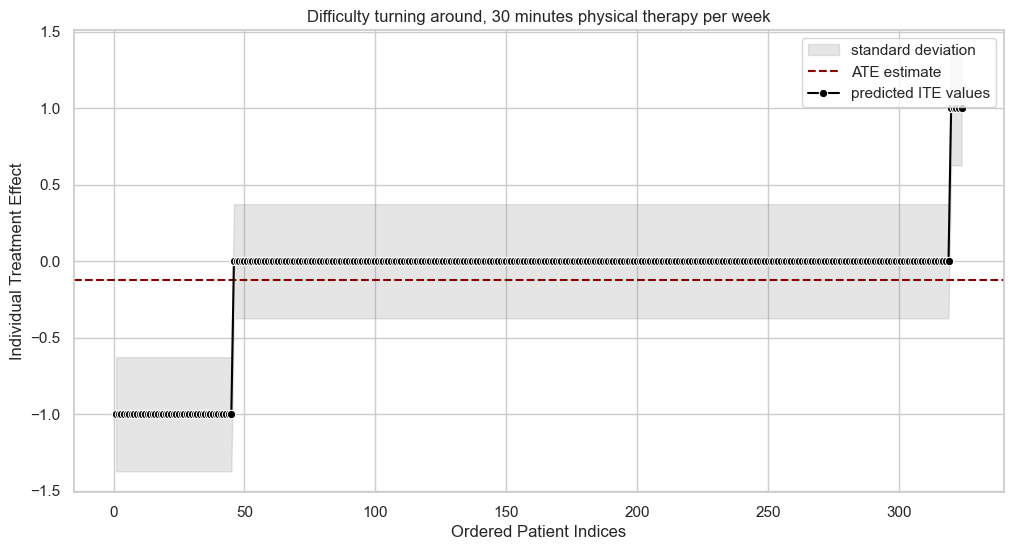

(-0.1642801371649169, -0.08263344308199665)
T-statistic: -5.949559670595177
P-value: 6.9914910138374525e-09
Result is statistically significant
               LogisticRegression(penalty='none')
ACC_C (Test)                             0.753086
ACC_T (Test)                             0.685185
ACC_C (Train)                            0.790451
ACC_T (Train)                            0.740053
ROC_AUC_C                                0.812042
ROC_AUC_T                                0.742413


In [195]:

model = [(LogisticRegression(penalty = 'none'), LogisticRegression(penalty = 'none'))]
np.random.seed(42)


for model1, model2 in model:
    print(str(model1))
    np.random.seed(42)
    metrics, predictions_t, predictions_c, y_test_t, y_test_c, ites_test,itest_treatment, ites_train, X_test_t, X_test_c, X_train_c, X_train_t, ites_test_proba,X_combined_c,X_combined_t = run_model_class1(n_bootstraps = 1, file = FILE, intervention = TREATMENT, outcome = OUTCOME, include_propensity = PROPENSITY, undersampled = UNDERSAMPLE, model1 = model1, model2 = model2, machine = str(model1), num_iter = 1, zmienne = zmienne)
    #visualise(predictions_t, predictions_c, y_test_t, y_test_c, machine=machine, target=target, intervention=intervention)
    np.random.seed(42)
    
    visualise_ites1(ites_test, machine = str(model1), intervention = TREATMENT, target = OUTCOME)
    
    #print("Probabilitiy of Hospitalization: ")
    confidence_interval(data=ites_test)
    significance(data=ites_test)
    
    
#     y_test = np.concatenate([y_test_t,y_test_c])
#     predictions = np.concatenate([predictions_t,predictions_c])
#     probabilities  =np.concatenate([ites_test_proba])
#     visualise_ites_proba(ites_test_proba, machine = machine, intervention = TREATMENT, target = OUTCOME)
    print(metrics)

LogisticRegression()
LogisticRegression()


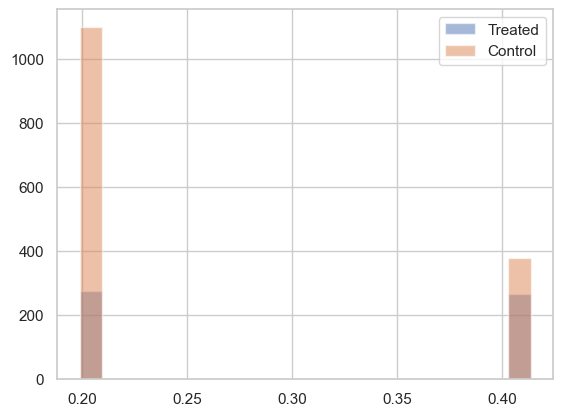

0.198842    273
0.413669    266
Name: ps, dtype: int64

0.198842    1100
0.413669     377
Name: ps, dtype: int64








CONTROL:
TREATMENT:
CONTROL
Test outcome under treatment 0.6358024691358025.
(Test) ATE -0.12962962962962965.
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'none', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
ATE -0.12962962962962962


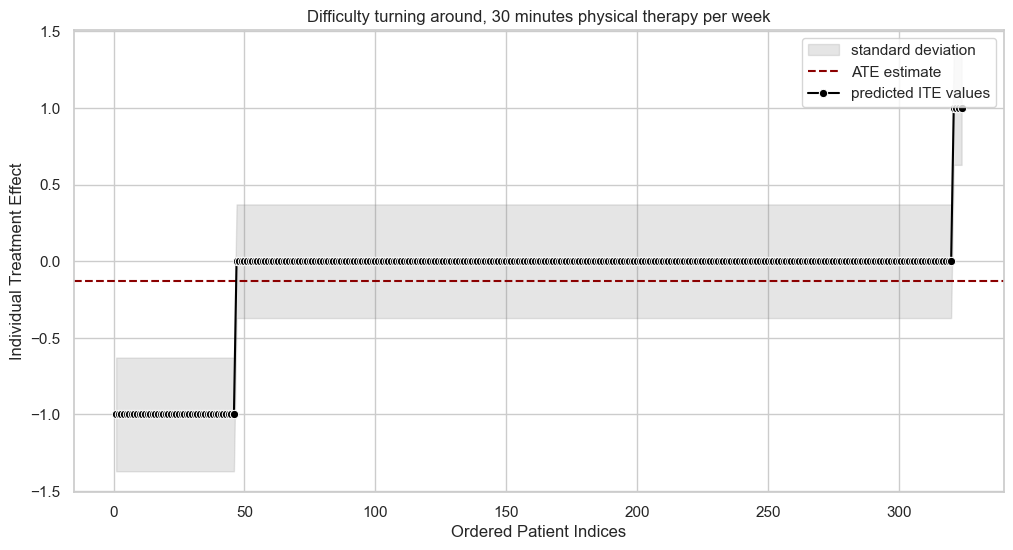

               LogisticRegression()
ACC_C (Test)               0.746914
ACC_T (Test)               0.685185
ACC_C (Train)              0.790451
ACC_T (Train)              0.740053
ROC_AUC_C                  0.809600
ROC_AUC_T                  0.742413


In [196]:
model = [(LogisticRegression(), LogisticRegression())]

import shap

for model0, model1 in model:
    np.random.seed(42)
    print(str(model0))
    print(str(model1))
    metrics, predictions_t, predictions_c, y_test_t, y_test_c, ites_test,itest_treatment, ites_train, X_test_t, X_test_c, X_train_c, X_train_t, ites_test_proba,X_combined_c,X_combined_t = run_model_class1(n_bootstraps = 1, file = FILE, intervention = TREATMENT, outcome = OUTCOME, include_propensity = PROPENSITY, undersampled = UNDERSAMPLE, model1 = model1, model2 = model2, machine = str(model1), num_iter = 1, zmienne = zmienne)
    

    
    
#     explainer = shap.Explainer(model1,X_combined_c )
#     shap_values_c =explainer(X_combined_c)
#     shap.summary_plot(shap_values_c, X_combined_c)
    
#     explainer_t =shap.Explainer(model2, X_combined_t)
#     shap_values_t =explainer_t.shap_values(X_combined_t)
#     shap.summary_plot(shap_values_t, X_combined_t)
    
# #     shap_values_combined =np.vstack((shap_values_c,shap_values_t))
# #     X_test_combined = pd.concat([X_test_c, X_test_t], axis =0 ).reset_index(drop=True)
# #     shap.summary_plot(shap_values_combined,X_test_combined)
    
    
    visualise_ites1(ites_test, machine =str(model1), intervention =TREATMENT, target =OUTCOME)
    print(metrics)

In [197]:
def ite_classification_for_test_training_treatment(x):
    if  -0.01 <= x <= 0.01:
        return "the same"
    elif x < -0.01:
        return "benefit"
    elif x > 0.01:
        return "worsening"
    

In [198]:
X_TEST_T = X_test_t
X_TEST_C = X_test_c
X_TRAIN_T = X_train_t
X_TRAIN_C = X_train_c



X_TEST_T['predictions'] = predictions_t
X_TEST_C['predictions'] = predictions_c

X_TEST_TRAIN = pd.concat([ X_TRAIN_T,X_TEST_T])
# y_test = pd.concat([y_test_t, y_test_c])
# X_TEST['OutcomeT1'] =y_test
X_TEST_TRAIN['ITES'] =itest_treatment


In [199]:
X_TEST_TRAIN['benefit']= X_TEST_TRAIN['ITES'].apply(ite_classification_for_test_training_treatment)

In [200]:
# for x in X_TEST_TRAIN.columns:
#     print(pd.crosstab(X_TEST_TRAIN[x], X_TEST_TRAIN['benefit'], normalize ='index')*100)


In [201]:
# for x in X_TEST_TRAIN.columns:
#     print(pd.crosstab(X_TEST_TRAIN[x], X_TEST_TRAIN['benefit']))

In [202]:
def run_model_class1(n_bootstraps, file, model1, model2, machine, intervention, outcome, include_propensity, undersampled = False, num_iter = 1, zmienne =None):
    
    acc_c, acc_t, f1_c, f1_t = [], [], [], []
    train_acc_c, train_acc_t = [], []
    
    X_train_c, X_test_c, y_train_c, y_test_c, X_train_t, X_test_t, y_train_t, y_test_t= data_processing1(file, undersampled,
                                                                                                         include_propensity, machine,
                                                                                                         intervention, outcome,
                                                                                                         target='OutcomeT1',
                                                                                                         treatment='treatment', caliper=0.2,
                                                                                                       zmienne =zmienne )
   
    print("")

   
   
#     f_c = model1
#     f_c.fit(X_train_c, y_train_c)
#     predictions_c = f_c.predict(X_test_c)
#     predictions_c_proba = f_c.predict_proba(X_test_c)[:,1]
# #     print(predictions_c_proba)
#     print("CONTROL:")
#     coefficients_c =model1.coef_[0]
# #     print("WSPOLCZYNNIKI:", coefficients_c)
#     odds_ratios_c =np.exp(coefficients_c)
# #     print("OR", odds_ratios_c)
#     df_CONTROL = pd.DataFrame({
#         'Cecha': X_train_c.columns, 
#         'WSPOLCZYNNIKI': coefficients_c,
#         'OR' :odds_ratios_c
#     })
#     print(df_CONTROL)
    
    
#     # treated
#     f_t = model2
#     f_t.fit(X_train_t, y_train_t)
#     predictions_t = f_t.predict(X_test_t)
#     predictions_t_proba = f_t.predict_proba(X_test_t)[:,1]
    
#     print("TREATMENT:")
#     coefficients_t =model2.coef_[0]
# #     print("WSPOLCZYNNIKI:", coefficients_t)
#     odds_ratios_t =np.exp(coefficients_t)
# #     print("OR", odds_ratios_t)
#     df_TREATMENT = pd.DataFrame({
#         'Cecha': X_train_t.columns, 
#         'WSPOLCZYNNIKI': coefficients_t,
#         'OR' :odds_ratios_t
        
        
#     })
#     print(df_TREATMENT)
    
    
    
    np.random.seed(42)
    X_c = sm.add_constant(X_train_c)   
    X_t = sm.add_constant(X_train_t)
    np.random.seed(42)

    model0 =sm.Logit(y_train_c, X_c)
    np.random.seed(42)

    model1 =sm.Logit(y_train_t, X_t)
    np.random.seed(42)
#     model0 =sm.OLS(y_train_c, X_train_c)
#     model1 =sm.OLS(y_train_t, X_train_t)
    result0 =model0.fit()
    result1 = model1.fit()  
#     y_pred_c =result0.predict( sm.add_constant(X_train_c))
#     print(y_pred_c)
    
#     y_pred_t =result1.predict(sm.add_constant(X_train_t))
#     print(y_pred_t)
#     print(result0.summary())
#     print(result1.summary())
    
    
    
#     print(odds_ratios_c)
    
#     print(odds_ratios_t)
    
    return y_test_t, y_test_c, X_test_t, X_test_c, X_train_c, X_train_t, y_train_c, y_train_t


In [203]:
X_TEST_T = X_test_t
X_TEST_C = X_test_c
X_TEST_T['predictions'] = predictions_t
X_TEST_C['predictions'] = predictions_c
X_TEST = pd.concat([X_TEST_T, X_TEST_C])
y_test = pd.concat([y_test_t, y_test_c])
X_TEST['OutcomeT1'] =y_test
X_TEST['ITES'] =ites_test

X_TEST['ITESp'] = ites_test_proba
X_TEST['Benefit'] = X_TEST['ITESp'].apply(lambda x:
                                          1 if x <= -0.01 else  #positive
                                          2 if x>=0.01 else     # negative
                                          0  if (x> -0.01 and x< 0.01)   #neutral
                                         else None)


In [204]:
# for x in X_TEST.columns:
#     print(pd.crosstab(X_TEST[x],  X_TEST['Benefit'],normalize ='index')*100)


In [205]:
# for x in X_TEST.columns:
#     print(pd.crosstab( X_TEST['Benefit'],X_TEST[x], normalize ='index')*100)


In [206]:
X_TEST_T1 = X_test_t
X_TEST_C1 = X_test_c

X_TEST_T1['group'] =1
# print(X_TEST_T1.head())
X_TEST_C1['group'] =0
# print(X_TEST_C1.head())


# X_TEST_T['predictions'] = predictions_t
# X_TEST_C['predictions'] = predictions_c
X_TEST_end = pd.concat([X_TEST_T1, X_TEST_C1])
# y_test = pd.concat([y_test_t, y_test_c])
# X_TEST['OutcomeT1'] =y_test
# X_TEST['ITES'] =ites_test

X_TEST_end['ITESp'] = ites_test_proba
# print(X_TEST_end)

X_TEST_end.loc[X_TEST_end['group']==1, 'Benefit_t']= X_TEST_end['ITESp'].apply(lambda x:
                                          1 if x <= -0.01 else  #positive
                                          2 if x>=0.01 else     # negative
                                          0  if (x> -0.01 and x< 0.01)   #neutral
                                         else None)

# for x in X_TEST_end.columns:
#     print(pd.crosstab(X_TEST_end[x], X_TEST_end['Benefit_t'], normalize ='index')*100)


In [207]:
# for x in X_TEST_end.columns:
#     print(pd.crosstab(X_TEST_end[x], X_TEST_end['Benefit_t']))

In [208]:
X_TEST_end.loc[X_TEST_end['group']==0, 'Benefit_c']= X_TEST_end['ITESp'].apply(lambda x:
                                          1 if x <= -0.01 else  #positive
                                          2 if x>=0.01 else     # negative
                                          0  if (x> -0.01 and x< 0.01)   #neutral
                                         else None)

# for x in X_TEST_end.columns:
#     print(pd.crosstab(X_TEST_end[x], X_TEST_end['Benefit_c'], normalize ='index')*100)


In [209]:
# for x in X_TEST_end.columns:
#     print(pd.crosstab(X_TEST_end[x], X_TEST_end['Benefit_c']))

### 3.b Run More Models

These models can be run also. Feel free to remove some of the models, but please run at least:

- ``RandomForestClassifier()``
- ``MLPClassifier()``
- ``LogisticRegression()``

In [210]:
# model_lst = [(RandomForestClassifier(),RandomForestClassifier()), 
#             (MLPClassifier(), MLPClassifier()), (DecisionTreeClassifier(), DecisionTreeClassifier()),
#              (AdaBoostClassifier(), AdaBoostClassifier()), (GradientBoostingClassifier(), GradientBoostingClassifier()),
#              (ExtraTreesClassifier(),ExtraTreesClassifier()),(LogisticRegression(), LogisticRegression())]

# for model1, model2 in model_lst:
#     print(str(model1))
#     metrics, predictions_t, predictions_c, y_test_t, y_test_c, ites_test, ites_train, X_test_t, X_test_c, X_train_c, X_train_t, ites_test_proba = run_model_class(n_bootstraps = 1, file = FILE, intervention = TREATMENT, outcome = OUTCOME, include_propensity = PROPENSITY, undersampled = UNDERSAMPLE, model0 = model0, model1 = model1, machine = str(model1), num_iter = 1, zmienne = zmienne)
#     #visualise(predictions_t, predictions_c, y_test_t, y_test_c, machine=machine, target=target, intervention=intervention)
#     visualise_ites(ites_test, machine = str(model1), intervention = TREATMENT, target = OUTCOME)
#     #print("Probabilitiy of Hospitalization: ")
#     confidence_interval(data=ites_test)
#     significance(data=ites_test)
# #     visualise_ites_proba(ites_test_proba, machine = machine, intervention = TREATMENT, target = OUTCOME)
#     print(metrics)

## Part 4. Adaptive Model

In this last part, we will predict the treatment effect using an adaptive model. This model was developed by us. As can be seen, there is a bit more coding involved, but the benefit is that it is easier to adapt this model to our preferences. 

The first step is to make sure that our model runs on the proper device. 

Not included. Does not work with probabilistic outcomes.